In [ ]:
!pip install librosa

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Activation,Flatten,Dense,TimeDistributed,BatchNormalization,Dropout,Bidirectional,Conv1D,MaxPool1D
from tensorflow.keras.layers import Dot,RepeatVector,Input,Concatenate
import tensorflow.keras.optimizers as optimizer
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile

In [2]:
!pip install kaggle

In [4]:
!pip install google

In [5]:
from google.colab import files
files.upload()

MessageError: ignored

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carlthome/gtzan-genre-collection

 99% 1.13G/1.14G [00:29<00:00, 58.9MB/s]
100% 1.14G/1.14G [00:30<00:00, 40.7MB/s]


In [ ]:
!ls

gtzan-genre-collection.zip  kaggle.json  sample_data


In [ ]:
with ZipFile('gtzan-genre-collection.zip','r') as zip:
    zip.extractall()

In [ ]:
path = 'genres/'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

genre_to_file = {}
for g in genres:
	genre_to_file[g] = []
	for fname in os.listdir(path+g+'/'):
		genre_to_file[g].append(fname)


In [ ]:
print("------------------------------------Chroma Frequencies Loading------------------------------------")
i=0
j=0
y = np.zeros((1000,1))
chroma = np.zeros((1000,1290,12))
for g in genres:
	for fname in genre_to_file[g]:
		x,sr = librosa.load(path+g+'/'+fname,mono=True,duration=30)
		chroma[i] = librosa.feature.chroma_stft(x,sr)[:,:1290].T
		y[i] = j
		i += 1
	j += 1
	print('----------------------------------------',g,' finished---------------------------------------')
print("------------------------------------Chroma Frequencies Done------------------------------------")
print("------------------------------------------MFCCs Loading-----------------------------------------")
i=0
mfcc = np.zeros((1000,1290,20))
roll = np.zeros((1000,1290,1))
zcr = np.zeros((1000,1290,1))
centroid = np.zeros((1000,1290,1))
bw = np.zeros((1000,1290,1))
for g in genres:
	for fname in genre_to_file[g]:
		x,sr = librosa.load(path+g+'/'+fname,mono=True,duration=30)
		mfcc[i] = librosa.feature.mfcc(x,sr)[:,:1290].T
		roll[i] = librosa.feature.spectral_rolloff(x,sr)[:,:1290].T
		zcr[i] = librosa.feature.zero_crossing_rate(x)[:,:1290].T
		centroid[i] = librosa.feature.spectral_centroid(x,sr)[:,:1290].T
		bw[i] = librosa.feature.spectral_bandwidth(x,sr)[:,:1290].T        
		i += 1
	print('-----------------------------',g,' finished----------------------------------------------')
print("------------------------------------------MFCCs, Spec, ZCR Done-----------------------------------------")


------------------------------------Chroma Frequencies Loading------------------------------------
---------------------------------------- blues  finished---------------------------------------
---------------------------------------- classical  finished---------------------------------------
---------------------------------------- country  finished---------------------------------------
---------------------------------------- disco  finished---------------------------------------
---------------------------------------- hiphop  finished---------------------------------------
---------------------------------------- jazz  finished---------------------------------------
---------------------------------------- metal  finished---------------------------------------
---------------------------------------- pop  finished---------------------------------------
---------------------------------------- reggae  finished---------------------------------------
--------------------------------

In [ ]:
print("-------------------------------Concatenation Started------------------------------------------")
X = np.concatenate((chroma,mfcc,roll,zcr),axis=-1)
print("-----------------------------------Concatenation Done------------------------------------------")

-------------------------------Concatenation Started------------------------------------------
-----------------------------------Concatenation Done------------------------------------------


In [ ]:
y_fin=np.dot(y,np.array([1,1]).reshape((1,2))).ravel().reshape((2*y.shape[0],1))


In [ ]:
#1290/2
X = X.reshape((2000,645,34))

In [ ]:
y_fin.shape,X.shape

((2000, 1), (2000, 645, 34))

In [ ]:
print("-------------------------Split into Train and Cross Validation Data--------------------------")
y = tensorflow.keras.utils.to_categorical(y_fin,10)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15)
print('---------------------Training and Cross Validation Matrices Made-----------------------------\n')

-------------------------Split into Train and Cross Validation Data--------------------------
---------------------Training and Cross Validation Matrices Made-----------------------------



In [ ]:
X_train.shape

(1700, 645, 34)

In [ ]:
print('---------------------Training and Cross Validation Matrices Preprocessing-----------------------------\n')
scaler = StandardScaler()
num_instances,num_time_steps,num_features = X_train.shape
X_train = np.reshape(X_train, (-1, num_features))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))
num_instances,num_time_steps,num_features = X_test.shape
X_test = np.reshape(X_test, (-1, num_features))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (num_instances, num_time_steps, num_features))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

---------------------Training and Cross Validation Matrices Preprocessing-----------------------------

(1700, 645, 34) (1700, 10) (300, 645, 34) (300, 10)


In [ ]:
def model_building():
	model = Sequential()
	model.add(TimeDistributed(Dense(128,activation='tanh'),input_shape=(X.shape[1:])))
	model.add(TimeDistributed(Dropout(0.2)))
	model.add(TimeDistributed(Dense(64,activation='tanh')))
	model.add(TimeDistributed(Dropout(0.2)))
	model.add(TimeDistributed(Dense(32,activation='tanh')))
	model.add(TimeDistributed(Dropout(0.2)))
	model.add(LSTM(64,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(32,activation='tanh',return_sequences=False))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(Dense(10,activation='softmax'))
	return model

In [ ]:
def model_building_1():
	model = Sequential()
	model.add(TimeDistributed(Dense(128,activation='tanh'),input_shape=(X.shape[1:])))
	model.add(TimeDistributed(Dropout(0.2)))
	#model.add(TimeDistributed(Dense(128,activation='tanh')))
	#model.add(TimeDistributed(Dropout(0.2)))
	model.add(TimeDistributed(Dense(32,activation='tanh')))
	model.add(TimeDistributed(Dropout(0.2)))
	#model.add(TimeDistributed(Dense(32,activation='tanh')))
	#model.add(TimeDistributed(Dropout(0.2)))
	model.add(LSTM(128,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(64,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(32,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(16,activation='tanh',return_sequences=False))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(Dense(10,activation='softmax'))
	return model

In [ ]:
def one_step_attention(a,s_prev,time_steps):
	s_prev = RepeatVector(time_steps)(s_prev)
	concat = Concatenate(axis=-1)([a,s_prev])
	e = Dense(10,activation='tanh')(concat)
	energies = Dense(1,activation='relu')(e)
	alpha = Activation('softmax')(energies)
	context = Dot(axes=1)([a,alpha])
	return context

def attention_layer(n_bi,n_po,time_steps,feature_size):
	X = Input(shape=(time_steps,feature_size))
	s0 = Input(shape=(n_po,))
	c0 = Input(shape=(n_po,))
	Y_1 = TimeDistributed(Dense(128,activation='relu'))(X)
	#Y_1 = TimeDistributed(BatchNormalization())(Y_2)
	Y = TimeDistributed(Dropout(0.3))(Y_1)
	Z_1 = TimeDistributed(Dense(64,activation='relu'))(Y)
	#Z_1 = TimeDistributed(BatchNormalization())(Z_2)
	Z = TimeDistributed(Dropout(0.3))(Z_1)
	a = Bidirectional(LSTM(n_bi,return_sequences=True))(Z)
	context = one_step_attention(a,s0,time_steps)
	s,m,c = LSTM(n_po,return_state=True)(context,initial_state=[s0,c0])
	out = Dense(10,activation='softmax')(s)

	model = Model(inputs=[X,s0,c0],outputs=out)
	return model    

In [ ]:
def model_building_cnn_rnn():
	model = Sequential()
	model.add(Conv1D(64,(3,3),activation='relu'))
    model.add(MaxPool1D((2,2),strides=2))
	model.add(Conv1D(32,(3,3),activation='relu'))
    model.add(MaxPool1D((2,2),strides=2))
	model.add(Conv1D(16,(3,3),activation='relu'))
    model.add(MaxPool1D((2,2),strides=2))
    model.add(LSTM(128,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(64,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(32,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(LSTM(16,activation='tanh',return_sequences=False))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
	model.add(Dense(10,activation='softmax'))
	return model

In [ ]:
model = attention_layer(64,64,X.shape[1],X.shape[2])
opt = optimizer.Adam(lr=8e-4,decay=4e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
print('------------------------------Model Compilation Done------------------------------------\n')
print(model.summary())

------------------------------Model Compilation Done------------------------------------

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 645, 34)]    0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 645, 128)     4480        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 645, 128)     0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 645, 64)      8256        time_distributed_1[0][0]         
____

In [ ]:
# WITH 1290 TIMESTEPS
print('------------------------------Model Training Started------------------------------------\n')
history = model.fit([X_train,np.zeros((850,64)),np.zeros((850,64))],y_train,epochs=50,batch_size=64,validation_data=([X_test,np.zeros((150,64)),np.zeros((150,64))],y_test))

------------------------------Model Training Started------------------------------------

Epoch 1/50
14/14 [==============================] - 6s 416ms/step - loss: 2.4174 - accuracy: 0.0988 - val_loss: 2.4053 - val_accuracy: 0.1133
Epoch 2/50
14/14 [==============================] - 4s 320ms/step - loss: 2.3250 - accuracy: 0.1059 - val_loss: 2.3196 - val_accuracy: 0.1733
Epoch 3/50
14/14 [==============================] - 4s 318ms/step - loss: 2.2655 - accuracy: 0.1376 - val_loss: 2.2254 - val_accuracy: 0.1800
Epoch 4/50
14/14 [==============================] - 4s 318ms/step - loss: 2.1910 - accuracy: 0.1824 - val_loss: 2.1932 - val_accuracy: 0.1533
Epoch 5/50
14/14 [==============================] - 5s 349ms/step - loss: 2.1841 - accuracy: 0.1953 - val_loss: 2.0938 - val_accuracy: 0.1800
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 2.1315 - accuracy: 0.2094 - val_loss: 2.0594 - val_accuracy: 0.2067
Epoch 7/50
14/14 [==============================] - 4s 319

In [ ]:
# WITH 645 TIMESTEPS
print('------------------------------Model Training Started------------------------------------\n')
history = model.fit([X_train,np.zeros((1700,64)),np.zeros((1700,64))],y_train,epochs=30,batch_size=64,validation_data=([X_test,np.zeros((300,64)),np.zeros((300,64))],y_test))

------------------------------Model Training Started------------------------------------

Epoch 1/50
27/27 [==============================] - 8s 299ms/step - loss: 2.2853 - accuracy: 0.1571 - val_loss: 2.1603 - val_accuracy: 0.2333
Epoch 2/50
27/27 [==============================] - 6s 233ms/step - loss: 2.0617 - accuracy: 0.2465 - val_loss: 1.9749 - val_accuracy: 0.2867
Epoch 3/50
27/27 [==============================] - 6s 231ms/step - loss: 1.8750 - accuracy: 0.3465 - val_loss: 1.7616 - val_accuracy: 0.4233
Epoch 4/50
27/27 [==============================] - 6s 228ms/step - loss: 1.6514 - accuracy: 0.4459 - val_loss: 1.6249 - val_accuracy: 0.4267
Epoch 5/50
27/27 [==============================] - 6s 220ms/step - loss: 1.4769 - accuracy: 0.4841 - val_loss: 1.4510 - val_accuracy: 0.4833
Epoch 6/50
27/27 [==============================] - 6s 216ms/step - loss: 1.3549 - accuracy: 0.5229 - val_loss: 1.4325 - val_accuracy: 0.4967
Epoch 7/50
27/27 [==============================] - 6s 207

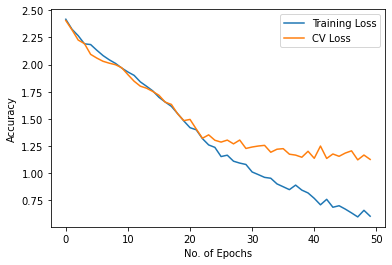

In [ ]:
plt.plot(history.history['loss'],label='Training Loss(1290)')
plt.plot(history.history['val_loss'],label='CV Loss(1290)')
plt.xlabel('No. of Epochs')
plt.ylabel("Accuracy")
plt.legend()

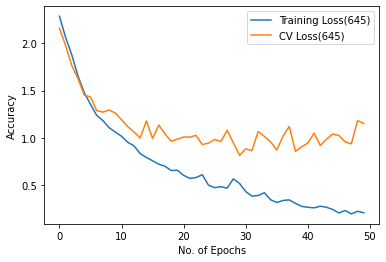

In [ ]:
plt.plot(history.history['loss'],label='Training Loss(645)')
plt.plot(history.history['val_loss'],label='CV Loss(645)')
plt.xlabel('No. of Epochs')
plt.ylabel("Accuracy")
plt.legend()

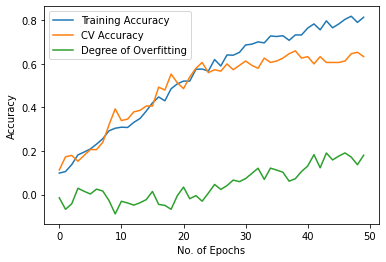

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='CV Accuracy')
plt.plot([history.history['accuracy'][i]-history.history['val_accuracy'][i] for i in range(len(history.history['val_accuracy']))],label='Degree of Overfitting')
plt.xlabel('No. of Epochs')
plt.ylabel("Accuracy")
plt.legend()

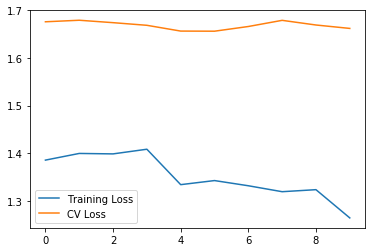

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='CV Loss')
plt.legend()

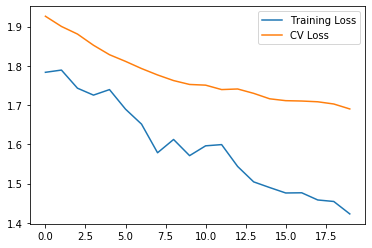

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='CV Loss')
plt.legend()

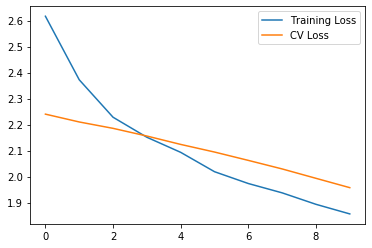

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='CV Loss')
plt.legend()